# Определение возраста покупателей

## Пользовательские функции

In [1]:
#  Функция для первичного анализа дата-сета
def analyze_df(df):
    # выводим размерность датафрейма
    display("Размерность датафрейма:")
    display(df.shape)

    
    # выводим информацию о датафрейме
    display("Информация о датафрейме:")
    display(df.info())

    
    # выводим статистическую информацию о датафрейме
    display("Статистическая информация о датафрейме:")
    display(df.describe())
    

    # выводим первые 10 строк датафрейма
    display("Первые 10 строк датафрейма:")
    display(df.head(10))
    

    # выодим кол-во пропусков
    display("Кол-во пропусков")
    display(df.isna().sum()[df.isna().sum() > 0])
    
    
    # выодим кол-во дубликатов
    display("Кол-во дубликатов")
    display(df.duplicated().sum()[df.duplicated().sum() > 0])
    
    # выводим типы данных в столбцах
    display("Типы данных в столбцах")
    display(df.dtypes)
    
    # выводим график распределения данных в столбцах
    plt.figure(figsize=(12, 8))
    df['real_age'].plot.hist(bins=30)
    plt.title('Распределение возраста')
    plt.xlabel('Возраст')
    plt.ylabel('Частота')
    plt.show()

# Импорты

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import gdal
import csv

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam

# Загрузка дата-сета

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/datasets/faces/labels.csv'

# EDA

'Размерность датафрейма:'

(7591, 2)

'Информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

'Статистическая информация о датафрейме:'

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


'Первые 10 строк датафрейма:'

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


'Кол-во пропусков'

Series([], dtype: int64)

'Кол-во дубликатов'

array([], dtype=int64)

'Типы данных в столбцах'

file_name    object
real_age      int64
dtype: object

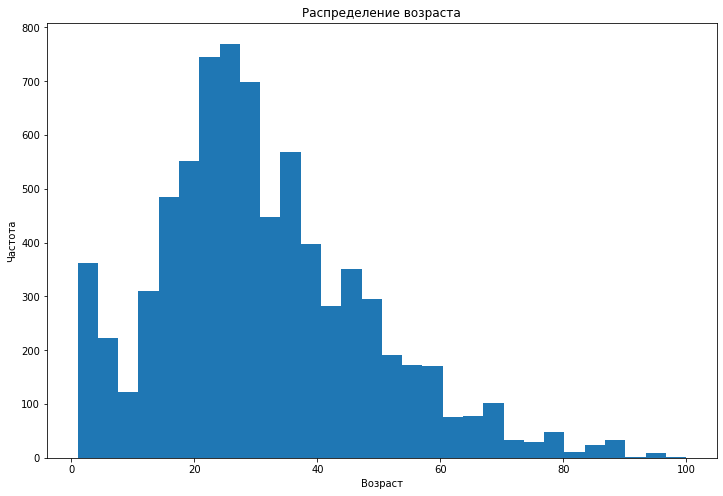

In [ ]:
analyze_df(labels)

In [ ]:
train_datagen = ImageDataGenerator(validation_split=0.25,
                                   rescale=1./255,
                                   
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   
                                   rotation_range=90,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 

In [ ]:
validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
validation_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 

In [4]:
# Выводим 10 изображений из первого батча обучающей выборки
with open('/datasets/faces/labels.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader, None)
  images = []
  for row in reader:
    images.append(row[0])

# Отображаем первые 10 изображений
for i in range(10):
  img = mpimg.imread(images[i])

  # Plot the image
  fig, ax = plt.subplots(1, 1, figsize=(12,12))
  for a in fig.get_axes():
    a.axis('off')

  ax.imshow(img)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/datasets/faces/labels.csv'

# Вывод о EDA

Дата-сет состоит из 7591 строк и 2 столбцов. В первом хранятся названия файлов, во втором реальный возраст людей на фотографиях.\
Большая часть изображенных людей находится в возрасте от 16 до 40 со всплеском около 0 - 6 лет.\
Выборка поделена в соотношении 75:25, то есть 5694:1897 тестовой к валидационной соответственно.\
Пропусков и дубликатов в дата-сете нет.\
Касаемо самих изображений, в них отличается фон, цветовая гамма (цветные и ч/б) и размеры,это добавляет сложности для нейросети.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras


def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.1,
    )

    return datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123,
    )


def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123,
    )


def create_model(input_shape):
    
    backbone = ResNet50(
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        input_shape=input_shape, 
        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0005), 
                  loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs, batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True)
    return model

```

```

60/60 - 9s - loss: 76.3653 - mean_absolute_error: 6.6379
Test MAE: 6.6379

```

## Анализ обученной модели

Обучение было проведено на 20 эпохах. После 17 метрика начала расти, можно сделать вывод о том, что модель немного переобучилась.\
Однако метрика качества была достигнута.\
Дальнейшее улучшение метрики можно достичь путем улучщения качества входных данных и регуляризацией l2/
Применение модели в бизнесе рекомендовано ограничить лишь вспомогательной функцией, так как ошибка может критически повлиять в районе пороговых значений (например совершеннолетие, пенсионный возраст и тд)

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы